In [1]:
%%html
<style>
    #notebook-container{
    width: 100%
    }
</style>

In [76]:
import numpy as np #importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
import statsmodels.stats as sm_stat

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from scipy import stats


sb.set()



In [64]:
telco_df = pd.read_csv('telco.txt', sep='\t') #load dataset
telco_df.head()

,tenure,age,marital,address,income,ed,employ,retire,gender,longmon,wiremon,churn
1,13,44,Married,9,64,College degree,5,No,Male,3.70,0.0,Yes
2,11,33,Married,7,136,Post-undergraduate degree,5,No,Male,4.40,35.7,Yes
3,68,52,Married,24,116,Did not complete high school,29,No,Female,18.15,0.0,No
4,33,33,Unmarried,12,33,High school degree,0,No,Female,9.45,0.0,Yes
5,23,30,Married,9,30,Did not complete high school,2,No,Male,6.30,0.0,No


# Problem 4

## Task 1
Description: Have a closer look at the deﬁnitions of the variables and analyze which of them might require a separate treatment. Consider for example the variable ed. There are two possibilities how the variable ed can be included into the model (one with dummy variables, the other one without dummies). Think about these two approaches and suggest which approach is more appropriate. Motivate your decision.

In given dataset the are multiple categorical variables such as:
- marital with values Married and Unmarried;
- retire with Yes and No values;
- gender with Male and Female values;
- churn with values Yes and No;
- ed with 5 distinct values - Did not complete high school, High school degree, Some college, College degree, Post-undergraduate degree.

Most common ways of including such variables into model are Dummy Variable Encoding and Label Encoding. Dummy Variable Encoding introduces $m-1$ dummy variables (with values 1 or 0 only) for each categorical variable with $m$ posible categories. It is important to introduce exqactly $m-1$ variables and not $m$ dummy variables because last category will be represented as 0 values for all other $m-1$ categories. Such category called reference category.

In our case, for variables marital, retire, gender and churn we need to introduce one dummy variabe per each of them. It is possible because all those variables are binary variables which taks either one values or another and there is no overlay between values possible. For variable ed we need to introduce 4 dummy variables for categories Did not complete high school, High school degree, Some college and College degree respectively. Category Post-undergraduate degree will be reference one and represented by this 4 dummy variables when all of them are equal to 0.

Another way to introduce ategorical variables into model is Label Encoding. With this approach for each categorical variable we introduce one new variable with respective numeric labels per category. So that, for variables marital, retire, gender and churn we will introduce label variables for each with values 0 and 1 (as for dummy variables). Simillary, for variable ed we will introduce one new label variable with values from 0 to 4 representing existing categories.

Below are transformed datasets using both approaches.

In [4]:
#Dummy Variable Encoding 

telco_dummy_df = pd.get_dummies(telco_df, columns=(['marital', 'retire', 'gender', 'churn', 'ed']))
telco_dummy_df.drop(columns=(['marital_Unmarried', 'retire_No', 'gender_Female', 'churn_No', 
                                               'ed_Post-undergraduate degree']), inplace=True)
telco_dummy_df.rename(columns={'marital_Married': 'marital_dummy', 'retire_Yes': 'retire_dummy', 
                               'gender_Male': 'gender_dummy', 'churn_Yes': 'churn_dummy', 
                              'ed_College degree': 'ed_dummy_college_degree', 
                               'ed_Did not complete high school': 'ed_dummy_no_high_school',
                              'ed_High school degree': 'ed_dummy_high_school',
                              'ed_Some college': 'ed_dummy_some_college'}, inplace=True)

telco_dummy_df.head()

,tenure,age,address,income,employ,longmon,wiremon,marital_dummy,retire_dummy,gender_dummy,churn_dummy,ed_dummy_college_degree,ed_dummy_no_high_school,ed_dummy_high_school,ed_dummy_some_college
1,13,44,9,64,5,3.70,0.0,1,0,1,1,1,0,0,0
2,11,33,7,136,5,4.40,35.7,1,0,1,1,0,0,0,0
3,68,52,24,116,29,18.15,0.0,1,0,0,0,0,1,0,0
4,33,33,12,33,0,9.45,0.0,0,0,0,1,0,0,1,0
5,23,30,9,30,2,6.30,0.0,1,0,1,0,0,1,0,0


In [5]:
#Label Encoding

telco_label_df = telco_df.copy()

# label_encoder = preprocessing.LabelEncoder() 

# telco_label_df['marital'] = label_encoder.fit_transform(telco_label_df['marital']) 
telco_label_df['marital'] = telco_label_df['marital'].astype('category')
telco_label_df['marital'] = telco_label_df['marital'].cat.codes

telco_label_df['retire'] = telco_label_df['retire'].astype('category')
telco_label_df['retire'] = telco_label_df['retire'].cat.codes

telco_label_df['gender'] = telco_label_df['gender'].astype('category')
telco_label_df['gender'] = telco_label_df['gender'].cat.codes

telco_label_df['churn'] = telco_label_df['churn'].astype('category')
telco_label_df['churn'] = telco_label_df['churn'].cat.codes

telco_label_df['ed'] = telco_label_df['ed'].astype('category')
telco_label_df['ed'] = telco_label_df['ed'].cat.codes

telco_label_df.head()

,tenure,age,marital,address,income,ed,employ,retire,gender,longmon,wiremon,churn
1,13,44,0,9,64,0,5,0,1,3.70,0.0,1
2,11,33,0,7,136,3,5,0,1,4.40,35.7,1
3,68,52,0,24,116,1,29,0,0,18.15,0.0,0
4,33,33,1,12,33,2,0,0,0,9.45,0.0,1
5,23,30,0,9,30,1,2,0,1,6.30,0.0,0


There are not that much difference between result we get applying Label Encoding and Dummy Variable Encoding to the categorical variables marital, retire, gender and churn. However, there is major difference with regards to categorical variable ed. 

For Label Encoding, ed now encoded by values from 0 to 4. Such number set will confuse regression model which will treat it like there is strong relation between variable values represented by numbers 4>3>2>1>0 and variable with value 4 two times bigger than variable with value 2. However, it is not the case and in real life we could not measure numerically difference between different levels of eduction which represented by this variable. As result, model will treat this values as related to each other and consider some of them as more important than others.

An opposite, using Dummy Variable Encoding we are replacing ed with four dummy variables each one with values 0 or 1. And fifth value encoded by setting all four dummy variables to 0. As result, model will consider all variables independently from each other and be able to assess impact of each ed dummy variable on target variable without giving more or less weight to other dummy variables. This will give us more precise model compare to Label Encoding approach. So that, we will be using Dummy Variable encoded dataset going forward.

## Task 2
Consider now the dependent variable and the interval (metric) scaled explanatory variables. Plot these data and decide if you wish to transform these x-variables and if there is a need to transform the y variable. You can also use some measure of skewness to decide about y. The variable wiremon shows a very speciﬁc pattern. How would you take it into account?

Skewness of target variable longmon = 2.96165
Skewness of explanatory variable tenure = 0.11169
Skewness of explanatory variable age = 0.35613
Skewness of explanatory variable address = 1.10459
Skewness of explanatory variable income = 6.63330
Skewness of explanatory variable employ = 1.05946
Skewness of explanatory variable wiremon = 1.60127


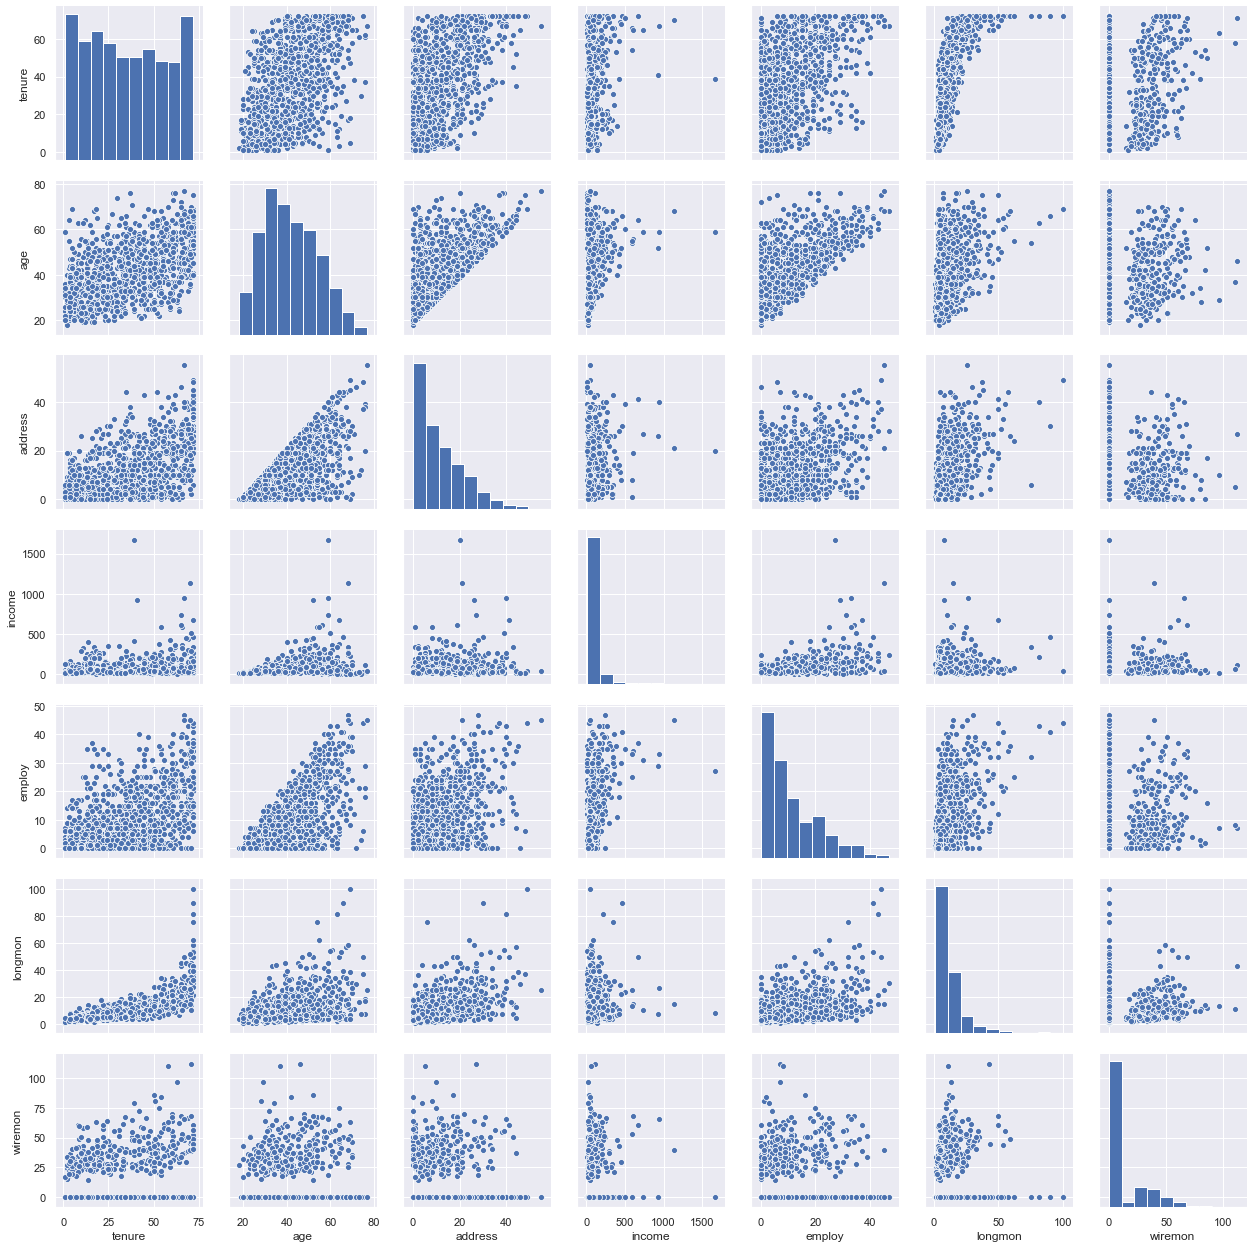

In [6]:
print("Skewness of target variable longmon = %.5f" %stats.skew(telco_dummy_df['longmon']))
print("Skewness of explanatory variable tenure = %.5f" %stats.skew(telco_dummy_df['tenure']))
print("Skewness of explanatory variable age = %.5f" %stats.skew(telco_dummy_df['age']))
print("Skewness of explanatory variable address = %.5f" %stats.skew(telco_dummy_df['address']))
print("Skewness of explanatory variable income = %.5f" %stats.skew(telco_dummy_df['income']))
print("Skewness of explanatory variable employ = %.5f" %stats.skew(telco_dummy_df['employ']))
print("Skewness of explanatory variable wiremon = %.5f" %stats.skew(telco_dummy_df['wiremon']))

#building pairplots filtering out all binary variables - those are not representable on scatterplots.
sb.pairplot(telco_dummy_df.filter(['tenure', 'age', 'address', 'income', 'employ', 'longmon', 'wiremon']))

After checking skewness of variables we could see that variables longmon, income, address, employ and wiremon are right-skewed. Hence we will need to apply transofrmations to data to make it close to normal. Dependign on variable I will apply either $log(x)$ or $\sqrt{x}$ transformations (selection depends whether or not 0 values exist for variable). 

Skewness after transformation of target variable longmon = 0.16619
Skewness after transformation of explanatory variable address = 0.09704
Skewness after transformation of explanatory variable income = 0.70029
Skewness after transformation of explanatory variable employ = 0.02168
Skewness after transformation of explanatory variable wiremon = 1.06007


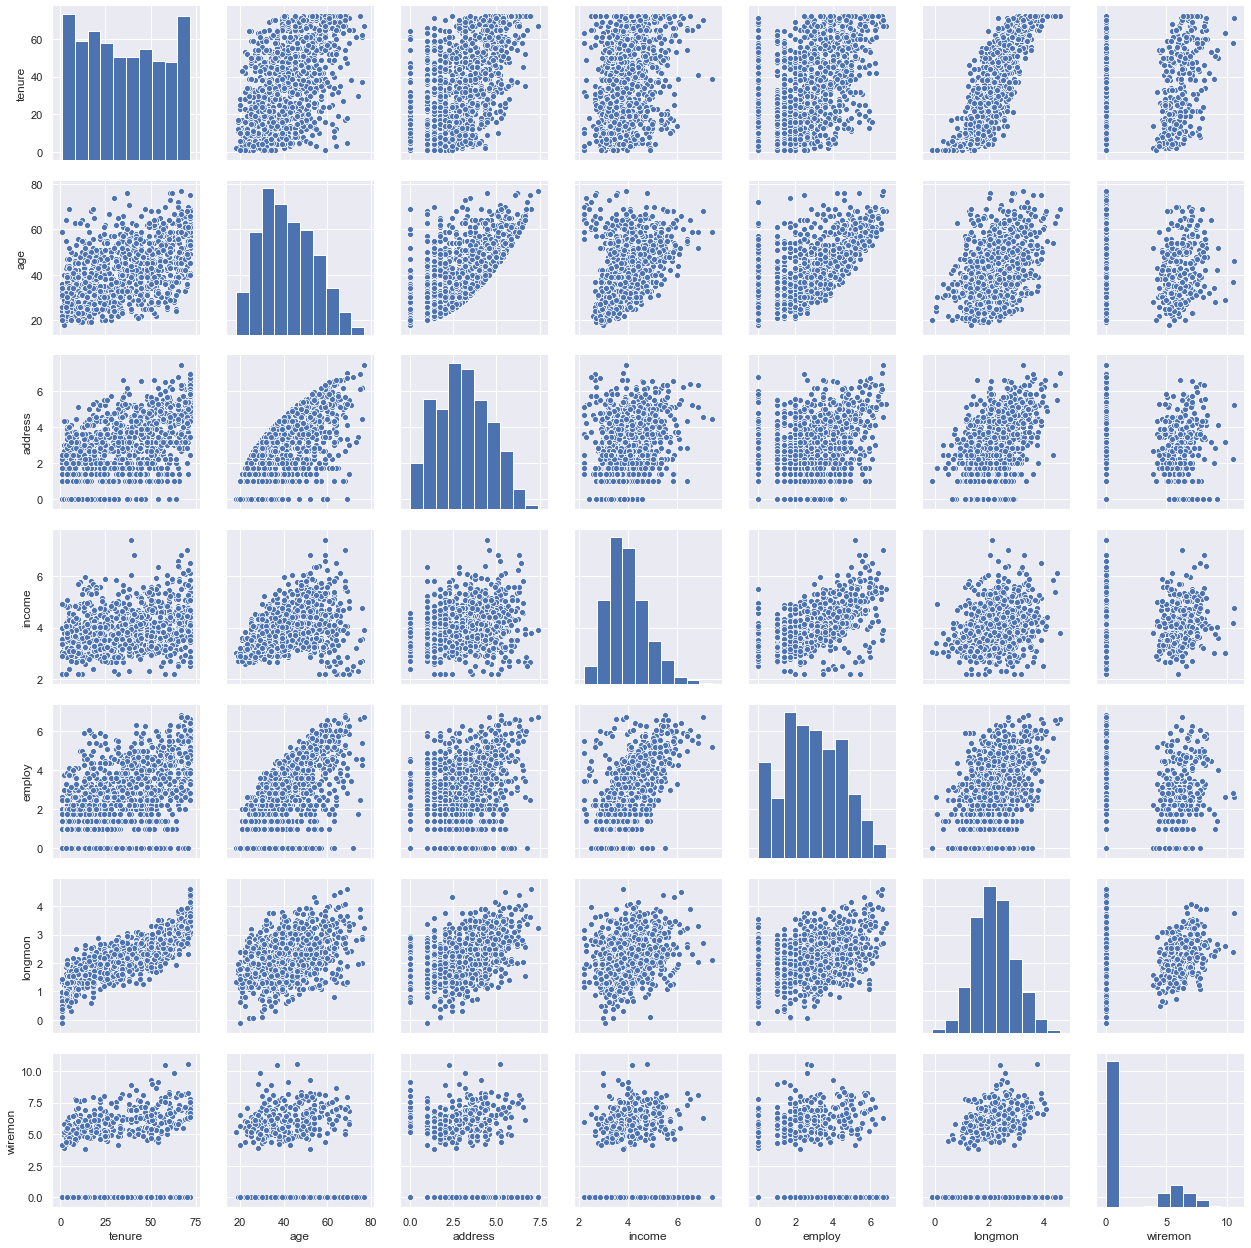

In [7]:
#transforming those variables which has skewness more than 1, checking skewness again and ploting it
telco_dummy_trans_df = telco_dummy_df.copy()

telco_dummy_trans_df['longmon'] = np.log(telco_dummy_trans_df['longmon']) #transforming data
telco_dummy_trans_df['income'] = np.log(telco_dummy_trans_df['income']) #using np.log for variables without 0 values
telco_dummy_trans_df['address'] = np.sqrt(telco_dummy_trans_df['address']) #using np.sqrt for variables with 0 values
telco_dummy_trans_df['employ'] = np.sqrt(telco_dummy_trans_df['employ'])
telco_dummy_trans_df['wiremon'] = np.sqrt(telco_dummy_trans_df['wiremon'])

print("Skewness after transformation of target variable longmon = %.5f" %stats.skew(telco_dummy_trans_df['longmon']))
print("Skewness after transformation of explanatory variable address = %.5f" %stats.skew(telco_dummy_trans_df['address']))
print("Skewness after transformation of explanatory variable income = %.5f" %stats.skew(telco_dummy_trans_df['income']))
print("Skewness after transformation of explanatory variable employ = %.5f" %stats.skew(telco_dummy_trans_df['employ']))
print("Skewness after transformation of explanatory variable wiremon = %.5f" %stats.skew(telco_dummy_trans_df['wiremon']))


#building pairplots filtering out all binary variables - those are not representable on scatterplots.
sb.pairplot(telco_dummy_trans_df.filter(['tenure', 'age', 'address', 'income', 'employ', 'longmon', 'wiremon']))

In [8]:
print("Amount of records with wiremon equal to 0 is %.2f%%" 
    %(telco_dummy_trans_df['wiremon'][telco_dummy_trans_df['wiremon'] == 0].count()
      /telco_dummy_trans_df['wiremon'].count()*100) )

Amount of records with wiremon equal to 0 is 70.40%


Variable wiremon indicates that around 70% customers in dataset not using internet access, hence no such data collected. As result, we see very high amount of 0 values here and it could not be fixed by simple transformation. Also, skewness test after transformation still shows that variable wiremon has right-skewed distribution. Due to those two facts, I will propose to transform it into dummy variable. In such case we wouldn't be intrested in how much is the difference between usage levels of internet, but we are intrested whether or not customer uses it.

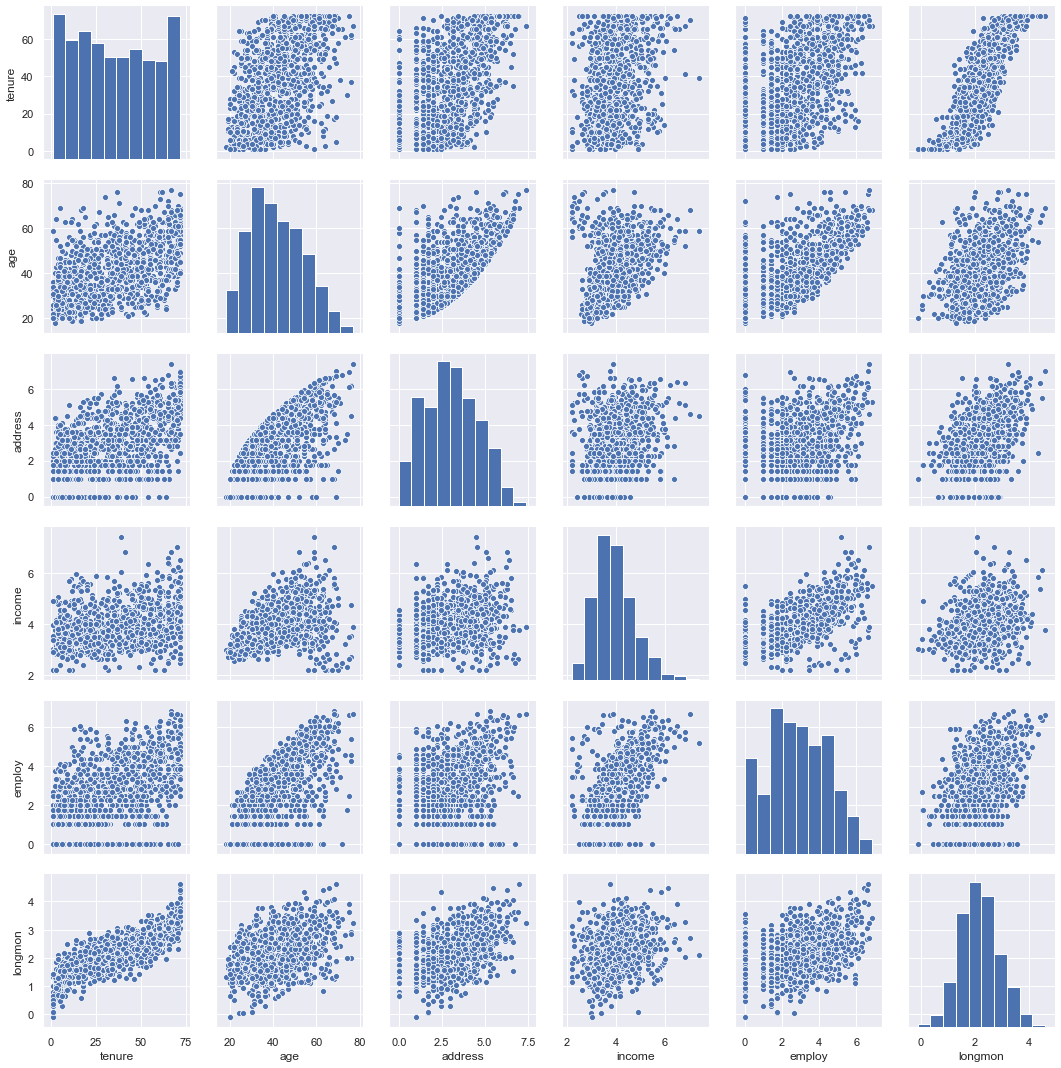

In [9]:
telco_dummy_trans_binwiremon_df = telco_dummy_trans_df.copy()

telco_dummy_trans_binwiremon_df.rename(columns={'wiremon': 'wiremon_dummy'}, inplace=True)
telco_dummy_trans_binwiremon_df['wiremon_dummy'] = telco_dummy_trans_binwiremon_df['wiremon_dummy'].apply(lambda x: 1 if x!=0 else 0)

#building pairplots filtering out all binary variables - those are not representable on scatterplots.
sb.pairplot(telco_dummy_trans_binwiremon_df.filter(['tenure', 'age', 'address', 'income', 'employ', 'longmon']))

## Task 3

After making up your decision about the above two problems run a simple linear regression. Pick up one of the regressors. Write down the corresponding hypothesis of the t-test. Provide the formula for the test statistics, explain the components of the formula and give the values for this components. Evaluate the goodness of the model. Explain in your own words the diﬀerence between $R^2$ and adjusted $R^2$.

In [10]:
telco_dummy_trans_binwiremon_norm_df = telco_dummy_trans_binwiremon_df.copy()

mm_scaler = preprocessing.MinMaxScaler() #Normalizing data first before regression for dependent variable and regressors
telco_dummy_trans_binwiremon_norm_df['longmon'] = mm_scaler.fit_transform(telco_dummy_trans_binwiremon_norm_df[['longmon']])
telco_dummy_trans_binwiremon_norm_df['income'] = mm_scaler.fit_transform(telco_dummy_trans_binwiremon_norm_df[['income']])
telco_dummy_trans_binwiremon_norm_df['tenure'] = mm_scaler.fit_transform(telco_dummy_trans_binwiremon_norm_df[['tenure']])
telco_dummy_trans_binwiremon_norm_df['age'] = mm_scaler.fit_transform(telco_dummy_trans_binwiremon_norm_df[['age']])
telco_dummy_trans_binwiremon_norm_df['address'] = mm_scaler.fit_transform(telco_dummy_trans_binwiremon_norm_df[['address']])
telco_dummy_trans_binwiremon_norm_df['employ'] = mm_scaler.fit_transform(telco_dummy_trans_binwiremon_norm_df[['employ']])

X = telco_dummy_trans_binwiremon_norm_df.drop('longmon', axis=1).copy()
X = sm.add_constant(X)

result = sm.OLS(telco_dummy_trans_binwiremon_norm_df['longmon'] , X).fit()
result.summary()

C:\Users\Mykhaylo_Manukyan\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                longmon   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     178.0
Date:                Fri, 03 Jan 2020   Prob (F-statistic):          5.13e-258
Time:                        00:26:27   Log-Likelihood:                 1070.3
No. Observations:                1000   AIC:                            -2111.
Df Residuals:                     985   BIC:                            -2037.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.2429      0.015     16.572      0.000       0.214       0.272
tenure                      0.4160      0.012     35.697      0.000       0.393       0.439
age                        -0.0232      0.021     -1.115      0.265      -0.064       0.018
address                     0.0280      0.017      1.633      0.103      -0.006       0.062
income                      0.0428      0.028      1.549      0.122      -0.011       0.097
employ                     -0.0067      0.019     -0.345      0.730      -0.044       0.031
wiremon_dummy              -0.0014      0.006     -0.233      0.816      -0.014       0.011
marital_dummy               0.0151      0.005      2.769      0.006       0.004       0.026
retire_dummy                0.0594      0.016      3.652      0.000       0.027       0.091
gender_dummy                0.0073      0.005      1.368      0.172      -0.003       0.018
churn_dummy                -0.0086      0.007     -1.312      0.190      -0.021       0.004
ed_dummy_college_degree     0.0241      0.012      2.056      0.040       0.001       0.047
ed_dummy_no_high_school     0.0027      0.013      0.208      0.835      -0.023       0.028
ed_dummy_high_school        0.0208      0.012      1.728      0.084      -0.003       0.044
ed_dummy_some_college       0.0175      0.012      1.439      0.150      -0.006       0.041
==============================================================================
Omnibus:                        2.536   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.281   Jarque-Bera (JB):                2.570
Skew:                          -0.053   Prob(JB):                        0.277
Kurtosis:                       3.225   Cond. No.                         21.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
#calculating covariance matrix C for income variable
X = telco_dummy_trans_binwiremon_norm_df.drop('longmon', axis=1).copy()
X = sm.add_constant(X)

C = np.linalg.inv( np.dot(X.T, X) )

C *= result.mse_resid

SE = np.sqrt(np.diag(C)) #getting square roots of covariance matrix elements

beta = result.params[4]
print("Parameter for income variable beta = %.5f" %beta)
se = SE[4] #taking only diagonal elements of covariance matrix correpsnding to income
print("Standard error se = %.5f" %se)
t = beta / se
print("t-statistic t = %.5f" %t)

N = result.nobs #number of observation
P = result.df_model #number of parameters
dof = N - P - 1 #calculating degree of freedom 
hp = 1.0 - stats.t( dof ).cdf( t )#one-tail probability
p = hp * 2.0 #calculating two-tail probabilty 
print("Probability value p = %.5f" %p)

Parameter for income variable beta = 0.04282
Standard error se = 0.02765
t-statistic t = 1.54872
Probability value p = 0.12177


I decided to use income variable as regressor. Hence, null hypotesis is $H_0: \beta_{income} = 0$ (income variable has no impact on dependent variable longmon). Respectively, $H_1: \beta_{income} \neq 0$  <br>
Formula to calculate test statistic is $t= \frac{\hat  \beta - \beta^*}{\sqrt{\hat {Var(\hat \beta)}}}$, where:
- $\hat \beta$ calculated value for respective $\beta$ based on OLS results;
- $\beta^*$ value of parameter $\beta$ from hypotesis, equal to 0 inour case;
- $\hat {Var(\hat \beta)}$ standard error, which is main diagonal elements of covariance matrix C

In [12]:
rss = np.sum((telco_dummy_trans_binwiremon_norm_df['longmon'] - result.fittedvalues)**2) #calculating Residual Sum of Squares
print("Residual Sum of Squares rss = %.5f" %rss)
ess = np.sum((result.fittedvalues - np.mean(telco_dummy_trans_binwiremon_norm_df['longmon']))**2) #calculating Explained Sum of Squares
print("Explained Sum of Squares ess = %.5f" %ess)
tss = rss+ess #Calculating Total Sum of Squares
print("Total Sum of Squares tss = %.5f" %tss)
R = ess/tss #Calculating R squared
print("R-squared R = %.5f" %R)

R_adj = 1 - (rss*(N-1))/(tss*(N-P-1)) #calculating adjusted R-squared
print("Adjusted R-squared R = %.5f" %R_adj)


Residual Sum of Squares rss = 6.88444
Explained Sum of Squares ess = 17.41313
Total Sum of Squares tss = 24.29757
R-squared R = 0.71666
Adjusted R-squared R = 0.71263


To evaluate goodness of a model we could calculated $R^2$ and adjusted $R_{adj}^2$ using formulas below:
- $R^2 = \frac{ess}{tss}$;
- $R_{adj}^2=1 - \frac{rss(N-1)}{tss(N-P-1)}$.
Where $ess$ is Explained Sum of Squares, $rss$ is Residual Sum of Squares, $tss$ is Total Sum of Squares, $N$ is number of observation, $P$ is number of parameters. 

Since $R^2$ increased with increase of number of parameters (P), it couldn't be used for selection of best model from pool of different models with different amount of parameters. In order to overcome this limitation, we could use adjusted $R_{adj}^2$ which is dependent on amount of model parameters and allow to compare models with different amount of parameters with each other to choose best one.

## Task 4

Compute manually the predicted values from the above regression and the residuals. Make two plots: residuals vs. predicted y's and predicted y's vs. true y's. What do you expect in both cases and why? Do the obtained figures support your expectations?

Predicted vs. Residuals values


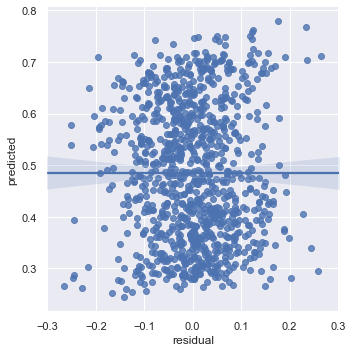

Residuals histogram


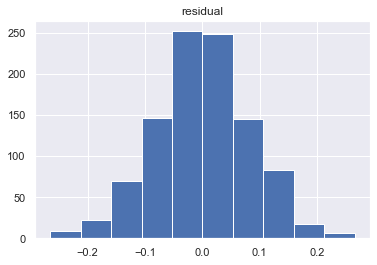

Predicted vs. True values


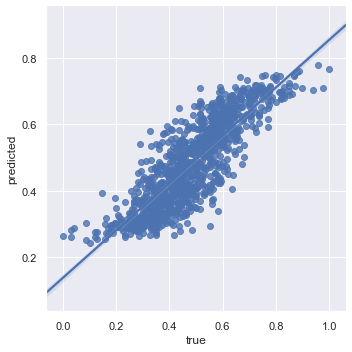

In [13]:
X = telco_dummy_trans_binwiremon_norm_df.drop('longmon', axis=1).copy()
X = sm.add_constant(X) #preparing data for manual calculation

Y_pred_man = np.dot(X, result.params) #calculating predicted values manually
Y_res_man = telco_dummy_trans_binwiremon_norm_df['longmon'] - Y_pred_man #calculating residuals manually

frame = { 'predicted': Y_pred_man, 'residual': Y_res_man } 
  
df = pd.DataFrame(frame) #creating dataset for visualisation

print("Predicted vs. Residuals values")
sb.lmplot(x='residual', y='predicted', data=df) #plotting predicted vs. residuals values
plt.show()

print("Residuals histogram")
df.hist('residual')
plt.show()

frame = { 'predicted': Y_pred_man, 'true': telco_dummy_trans_binwiremon_norm_df['longmon'] } 
  
df = pd.DataFrame(frame) #creating dataset for visualisation
print("Predicted vs. True values")
sb.lmplot(x='true', y='predicted', data=df) #plotting predicted vs. true values
plt.show()

For Predicted vs. True values plot expectation is that predicted values are close to true values, hence scatter plot should be closer to straight line. On this plot we observe exactly this behavior - all data cluttered around straight line. <br>
Speaking about Predicted vs. Residual values - expectations here that residuals are equally spread around 0 mean, which confirms that predicted values coincides with true values or located in proximity of them. Also, important here not to have any outliers for the residuals. To confirm that residuals are equally spread around mean of 0, I have built histogram for the residuals - as result, on histogram we could observe equal distribution of residuals around 0 mean.

## Task 5

If you wish to argue that education is insignificant and use the model with dummies than you have to check the simultaneous insignificance of all dummies which stem from the factor variable ed. Run a test for general linear hypothesis and conclude about the significance of ed. Write down the matrix and the vector needed in the hypothesis.

In [14]:
R = np.zeros((4, len(telco_dummy_trans_binwiremon_norm_df.columns))) #writting down matrix R

R[0,11] = R[1, 12] = R[2, 13] = R[3, 14] = 1

r = np.zeros((4, 1)) #writting down vector r

print("Executing F-test of the model for matrix R and vector r \n %s" %result.f_test((R, r)))

print("Matrix R = \n %s" %R)
print("Vector r = \n %s" %r)

Executing F-test of the model for matrix R and vector r 
 <F test: F=array([[2.5345383]]), p=0.03883216473691277, df_denom=985, df_num=4>
Matrix R = 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Vector r = 
 [[0.]
 [0.]
 [0.]
 [0.]]


Null hypotesis: $H_0: \beta_{ed.dummy.college.degree} = \beta_{ed.dummy.no.high.school} = \beta_{ed.dummy.high.school} = \beta_{ed.dummy.some.college} = 0$ <br>
Alternative hypotesis: $H_1: \beta_{ed.dummy.college.degree} \neq 0$ or $\beta_{ed.dummy.no.high.school} \neq 0$ or $\beta_{ed.dummy.high.school} \neq 0$ or $\beta_{ed.dummy.some.college} \neq 0$ <br>
As per result of F-test p-value is p=0.03883 $<\alpha = 0.05$, hence we could reject null hypotesis and at least one of $\beta$ above is not equal to 0. So that, we could confirm that education related dummy variables are significant for our dependent variable longmon. <br>

## Task 6

Provide an economic interpretation for the parameters of "address", "ed" and "retire". Neglect the possible insignificance and keep in mind possible transformations of the variables.

Variable "address" represents years at current location and shows that with increase of time spent on the current location amount of long distance call also increases. However, since I have used sqrt transformation to variable "address" there is no way to interpret impact of this variable on predicted variable "longmon". 

Variable "ed" was splitted into 4 dummy variables with "Post-Undegraduate degree" as a reference category. For non-referenced categories coefficients are positive, hence we could make a conclusion that long distance calls increase for education categories other than "Post-Undegraduate degree" reference category. Also, we should consider that for education category "No High School" coefficient is not that high compare to reference one, so this dummy variable has very little impact on amount of long distant calls compare to reference one. 

Variable "retire" is a dummy variable and indicates that when person is retired amount of long distance calls increases, so retired persons are tend to have more often long distance calls.

For variables "ed" and "retire", considering that dependent variable "longmon" was transformed using natural log transformation, we could also derive a conclusion that respective coefficients represents a percentage change in amount of long distance calls with respect to reference category. For example, retired person makes approximately 6% more long distance callы compare to non-retired person. Simillary, person with "No high school" education makes only around 0,27% more long distance calls compare to reference category "Post-Undegraduate degree". Other education dummy variables gives between 1,75-2.5% increase in long dstance calls compare to reference education category "Post-Undegraduate degree".

## Task 7

Compute the 95% confidence intervals for the parameters of "address" and "income" and provide its economic meaning. Relate the CIs to the tests of significance, i.e. how would you use these intervals to decide about the significance of the corresponding explanatory variables? The CIs are computed relying on the assumption, that the residuals follow normal distribution. Is this assumption fulfilled? Run an appropriate
goodness-of-fit test.

In [15]:
print("Confidencce interval for variable address is from %.5f" %result.conf_int()[0][3], "to %.5f" %result.conf_int()[1][3])
print("Confidencce interval for variable income is from %.5f" %result.conf_int()[0][4], "to %.5f" %result.conf_int()[1][4])

Confidencce interval for variable address is from -0.00564 to 0.06166
Confidencce interval for variable income is from -0.01144 to 0.09708


95% confidence interval of coefficients for variables "address" and "income" indicates that with 95% probability coefficient value will be located within given interval. Also, we could explain it as increase in 1 unit of mentioned explanatory variables with 95% of probability will increase dependent variable for the value from confidence interval: (-0.00564; 0.06166) and (-0.01144; 0.09708) respectively. In a nutshell, the broader is interval the less precise given parameters will be because their volatility is high. Speaking about two given variables "address" and "income", we could see quite wide confidence interval, where lower bound even negative. This indicates that determined coefficients are unstable and in certain cases could take zero or negative values. Since for both variables intervals includes 0 value - it means that there is no strong correlation between dependent variable "longmon" and explanatory variables "address" and "income". We could consider those variables as not significant, due to fact that respective $\beta_{address}$ and $\beta_{income}$ could take 0 value, which is part of interval.

Since CIs computed based on students t-distribution which is closed to normal one, it is assumed that residuals of the model is normally distrubuted. To check this assumtpion we could use Kolmogorov-Smirnov one sample test with null hypotesis $H_0:residuals \sim N(\mu, \sigma)$ and alternative hypotesis $H_1: residuals \nsim N(\mu, \sigma)$.

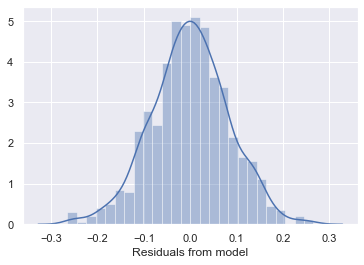

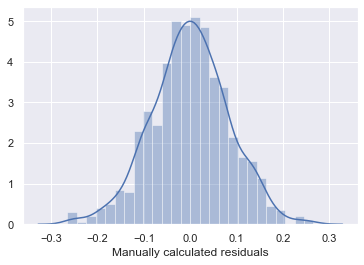

Calcualted mean of manual residuals distribution mu = -1.52985957235785e-15 and calculated standard deviation 0.08297 

p-value of Kolmogorov-Smirnov test for residuals from model 0.87093
p-value of Kolmogorov-Smirnov test for manually calcualted residuals 0.87093


In [16]:
sb.distplot(result.resid, axlabel='Residuals from model') #ploting manually calculated residuals and resduals from model
plt.show()
sb.distplot(Y_res_man, axlabel='Manually calculated residuals')
plt.show()

mu, sigma = np.mean(Y_res_man), np.std(Y_res_man) #calcualting approximate mean and deviation of the model
print("Calcualted mean of manual residuals distribution mu = %s" %mu, "and calculated standard deviation %.5f \n" %sigma)

#performing Kolmogorov-Smirnov test for manually calculated residuals and residuals from the model
print("p-value of Kolmogorov-Smirnov test for residuals from model %.5f" %stats.kstest(result.resid, 'norm', args=(mu, sigma))[1])
print("p-value of Kolmogorov-Smirnov test for manually calcualted residuals %.5f" %stats.kstest(Y_res_man, 'norm', args=(mu, sigma))[1])

Since for residuals p-value of Kolmogorov-Smirnov test is greater than threshold $\alpha = 0.05$ we couldn't reject null hypotesis $H_0:residuals \sim N(\mu, \sigma)$. This means that residuals are follow normal distribution and CIs were calcualted with correct assumtion about normality of residuals distribution.

## Task 8

Many of the variable appear insignificant and we should find the smallest model, which still has a good explanatory power. Choose this model using stepwise model selection (either based on the tests for $R^2$ or using AIC/BIC). Pick up the last step of the model selection procedure and explain in details how the method/approach works (or is implemented in your software). Work with this model in all the remaining steps.

In [34]:
def find_best_model(model, Y): #defining recursive method of step-wise backwards model selection using AIC as criteria
    X = model.drop('longmon', axis=1).copy() #performing simple regression for big model
    X = sm.add_constant(X)
    res = sm.OLS(Y , X).fit()
    X = X.drop('const', axis=1)
    
    min_aic = res.aic #setting minimal AIC and model values
    min_model = model.copy()
    is_better_model = False #setting flag to decide when to exit recursion
    
    for col in X.columns: #looping over columns of model and drop columns one-by-one
        Xi = X.drop(col, axis=1).copy()
        Xi = sm.add_constant(Xi)
        res_i = sm.OLS(Y, Xi).fit()
        if res_i.aic < min_aic: #compare AIC of model with one less column with bigger one AIC
            is_better_model = True #if more optimal model found, reassign minimal AIC and model values
            min_aic = res_i.aic
            min_model = model.drop(col, axis=1).copy()
    
    if is_better_model == True: #if there is a smaller model, call same method again to look for even better one
        min_aic, min_model = find_best_model(min_model, Y)
        
    return min_aic, min_model #return minimal model and AIC values
            

big_model = telco_dummy_trans_binwiremon_norm_df.copy() #setting full model

aic, best_model = find_best_model(big_model, telco_dummy_trans_binwiremon_norm_df['longmon']) #call method to find optimal model

print("Smallest achieved AIC=%.5f \n" %aic) #printing results
print("Optimal model contains %s columns:" %best_model.columns.size)
for col in best_model.columns:
    print(col)

Smallest achieved AIC=-2117.52698 

Optimal model contains 8 columns:
tenure
income
longmon
marital_dummy
retire_dummy
ed_dummy_college_degree
ed_dummy_high_school
ed_dummy_some_college


I've decided to use stepwise backward model selection (from general model to smaller optimal one) based on Akaike Information Criterion (AIC). Initially I've tried to use Bayes Information Criterion (BIC), but using BIC I got oversimplified model with few regressors only. After short research I've found that it is downside of BIC approach and I decided to switch to AIC instead.

I've implemented method for model selection on my own in form of recursive method. First of all, I am setting general model as an optimal one. Next, method takes general model, in a loop drop one column and compare AIC of general model with AIC of reduced one. If AIC of reduced model is less than AIC of general one, than we store this reduced model as an optimal one and continue checking other columns. In the final step, if reduced model is more optimal, then we call same method again passing reduced model and performing same algorithm again, but with reduced model. In case if no model has smaller AIC than the one passed to the method - most optimal model is found, no more recursive calls and method return optimal model as result of execution.

As result, optimal model consist of 8 columns (including dependent variable): "tenure", "income", "longmon", "marital_dummy", "retire_dummy", "ed_dummy_college_degree", "ed_dummy_high_school" and "ed_dummy_some_college". This model will be  used in all further tasks.

In [35]:
X = best_model.drop('longmon', axis=1).copy() #performing simple regression for optimal model found
X = sm.add_constant(X)
best_model_res = sm.OLS(best_model['longmon'] , X).fit()
best_model_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                longmon   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     354.9
Date:                Fri, 03 Jan 2020   Prob (F-statistic):          5.34e-265
Time:                        00:48:03   Log-Likelihood:                 1066.8
No. Observations:                1000   AIC:                            -2118.
Df Residuals:                     992   BIC:                            -2078.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.2472      0.009     28.638      0.000       0.230       0.264
tenure                      0.4232      0.010     42.535      0.000       0.404       0.443
income                      0.0287      0.019      1.487      0.137      -0.009       0.067
marital_dummy               0.0143      0.005      2.647      0.008       0.004       0.025
retire_dummy                0.0514      0.013      3.838      0.000       0.025       0.078
ed_dummy_college_degree     0.0216      0.008      2.853      0.004       0.007       0.036
ed_dummy_high_school        0.0184      0.007      2.594      0.010       0.004       0.032
ed_dummy_some_college       0.0149      0.008      1.922      0.055      -0.000       0.030
==============================================================================
Omnibus:                        2.694   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.260   Jarque-Bera (JB):                2.759
Skew:                          -0.054   Prob(JB):                        0.252
Kurtosis:                       3.233   Cond. No.                         10.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Task 9

Sometimes data contains outliers which induces bias in the parameter estimates. Check for outliers using Cook's distance and leverage. Have a closer look at the observation with the highest leverage (regardless if it is classified as an outlier or not). What makes this observation so outstanding (you may have a look at Box-plots for interval scaled variables or at the frequencies for binary/ordinal variables?

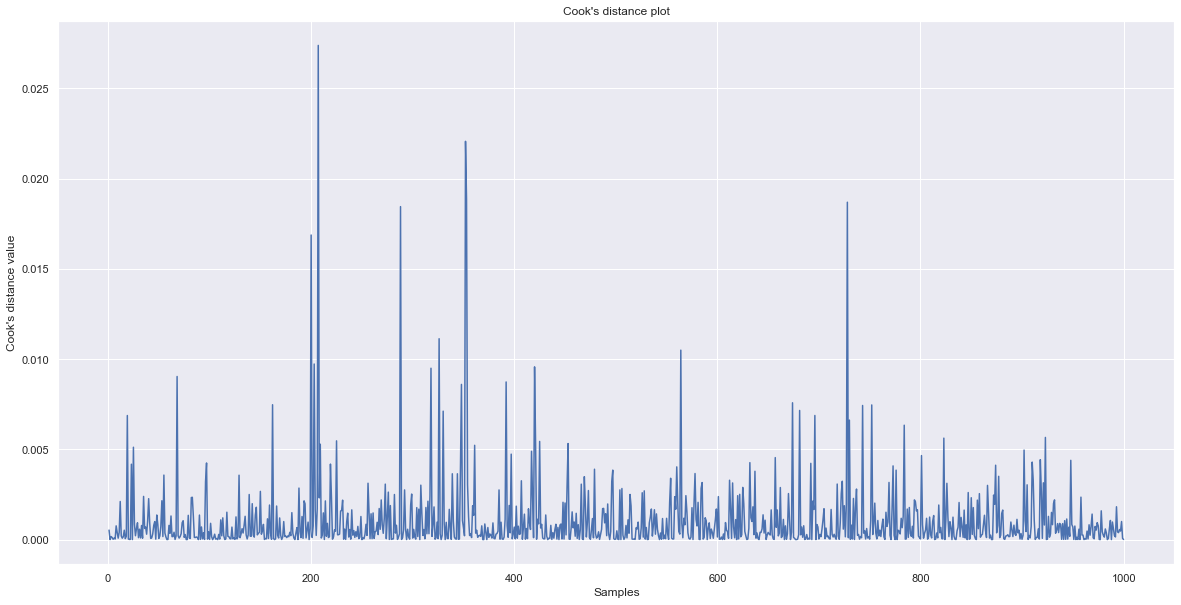

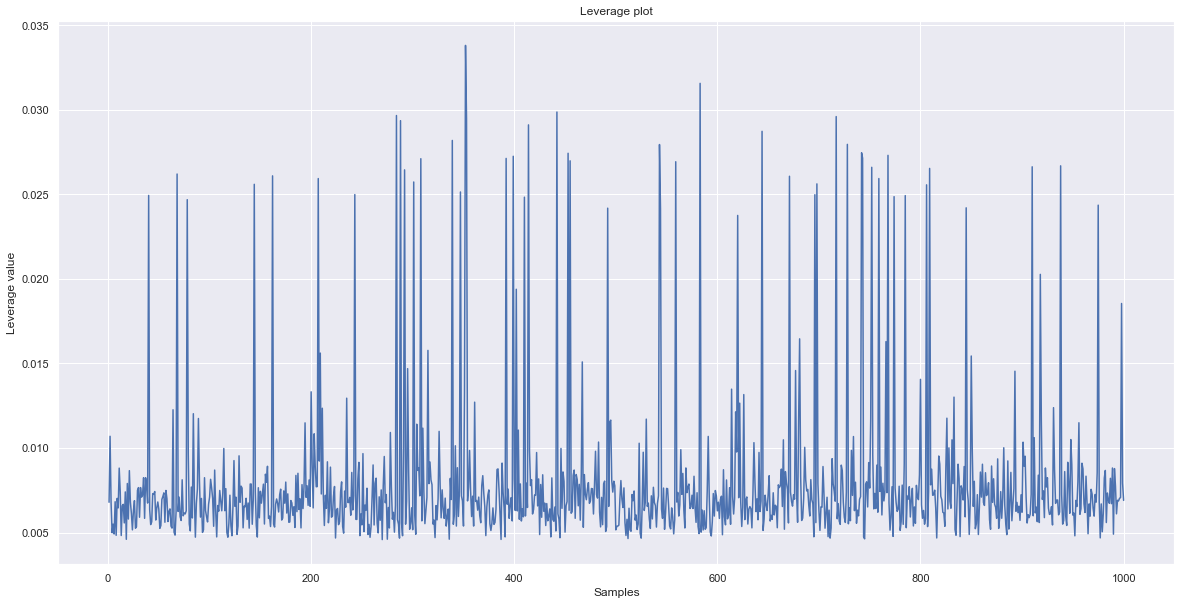

In [36]:
influence = best_model_res.get_influence() #calculating Cook`s distance to identify outliers in data
inf_summary = influence.summary_frame()

plt.figure(figsize=(20,10))
sb.lineplot(x=np.arange(1, inf_summary['cooks_d'].size+1, 1), y=inf_summary['cooks_d'])
plt.title("Cook\'s distance plot")
plt.ylabel("Cook\'s distance value")
plt.xlabel("Samples")
plt.show()

plt.figure(figsize=(20,10))
sb.lineplot(x=np.arange(1, inf_summary['hat_diag'].size+1, 1), y=inf_summary['hat_diag'])
plt.title("Leverage plot")
plt.ylabel("Leverage value")
plt.xlabel("Samples")
plt.show()

Plotting Cook's distance and Leverage values of optimal model. From plots we could see that some values have high Cook's distance compare to others. Also, according to Leverage plot, even more observations are far from others. Let's have a closer look on data with Leverage higher than 0.03.

In [37]:
ind_lev = inf_summary[inf_summary['hat_diag'] > 0.03 ].index #selecting records indices with high leverage

telco_df.iloc[ind_lev] #printing initial data for selected indices 

,tenure,age,marital,address,income,ed,employ,retire,gender,longmon,wiremon,churn
353,45,66,Unmarried,11,87,Some college,25,Yes,Female,6.05,0.0,No
584,35,40,Unmarried,5,49,Did not complete high school,20,No,Female,3.40,0.0,No


In [38]:
best_model.iloc[ind_lev] #printing data from optimal model for selected indices 

,tenure,income,longmon,marital_dummy,retire_dummy,ed_dummy_college_degree,ed_dummy_high_school,ed_dummy_some_college
353,0.619718,0.434434,0.404545,0,1,0,0,1
584,0.478873,0.324501,0.282193,0,0,0,0,0


Plotting box plots for continious variables and frequency plots for binary variables.

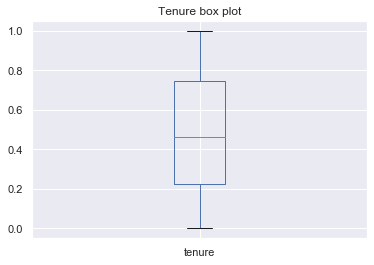

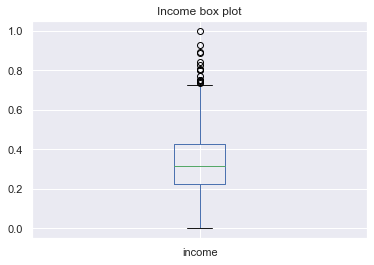

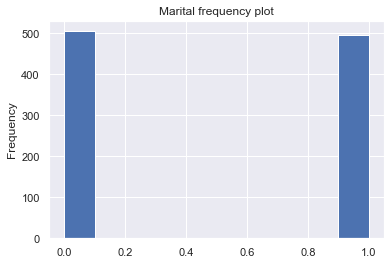

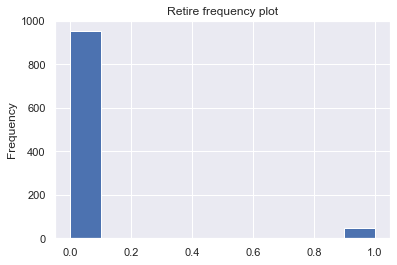

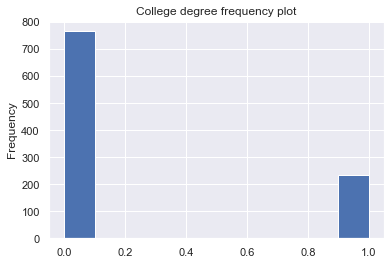

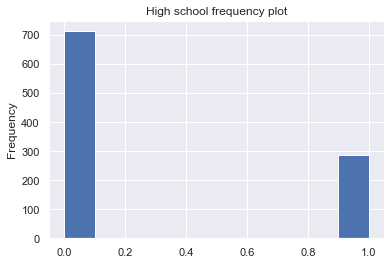

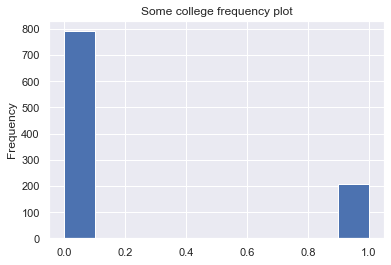

In [39]:
plt.title("Tenure box plot")
best_model['tenure'].plot(kind='box')
plt.show()

plt.title("Income box plot")
best_model['income'].plot(kind='box')
plt.show()

plt.title("Marital frequency plot")
best_model['marital_dummy'].plot(kind='hist')
plt.show()

plt.title("Retire frequency plot")
best_model['retire_dummy'].plot(kind='hist')
plt.show()

plt.title("College degree frequency plot")
best_model['ed_dummy_college_degree'].plot(kind='hist')
plt.show()

plt.title("High school frequency plot")
best_model['ed_dummy_high_school'].plot(kind='hist')
plt.show()

plt.title("Some college frequency plot")
best_model['ed_dummy_some_college'].plot(kind='hist')
plt.show()


One observation with high Leverage here is 66 years old unmarried female with some colledge education degree, which has 25 years of employment, retired already and has quite low long distance call amount. Here I think most outstanding attribute is retirment which is infrequent as per frequency plot.

Another observation with high Leverage is 40 years old unmarried female, which didn't completed high school, has 20 years of employment and has low long distance call amount as well. Here most outstanding attribute is no high school education, this category was droped from the optimal model.

## Task 10

Frequently data is missing. Pick up 5 rows in the data set and delete the value for "address". Implement at least two approaches to fill in these values. Write down the corresponding formulas/model and give motivation for your approach. If you use standard routines then check how exactly the data imputation is implemented. How would you proceed if the value of the binary variable "retire" is missing? Implementation is not required.

Using built-in DataFrame method for interpolation of missing values. It is based on SciPy library for interpolation.

In [40]:
telco_dummy_trans_binwiremon_norm_impute1_df = telco_dummy_trans_binwiremon_norm_df.copy() #creating new DF with  NaN data
telco_dummy_trans_binwiremon_norm_impute2_df = telco_dummy_trans_binwiremon_norm_df.copy()

telco_dummy_trans_binwiremon_norm_impute1_df.loc[100, 'address'] = None #setting data to NaN
telco_dummy_trans_binwiremon_norm_impute1_df.loc[250, 'address'] = None
telco_dummy_trans_binwiremon_norm_impute1_df.loc[500, 'address'] = None
telco_dummy_trans_binwiremon_norm_impute1_df.loc[750, 'address'] = None
telco_dummy_trans_binwiremon_norm_impute1_df.loc[1000, 'address'] = None

print("First dataset for imputation with NaNs:")
print(telco_dummy_trans_binwiremon_norm_impute1_df.loc[100, 'address']) #printing lines with NaN
print(telco_dummy_trans_binwiremon_norm_impute1_df.loc[250, 'address'])
print(telco_dummy_trans_binwiremon_norm_impute1_df.loc[500, 'address'])
print(telco_dummy_trans_binwiremon_norm_impute1_df.loc[750, 'address'])
print(telco_dummy_trans_binwiremon_norm_impute1_df.loc[1000, 'address'])

telco_dummy_trans_binwiremon_norm_impute2_df.loc[100, 'address'] = None #setting data to NaN
telco_dummy_trans_binwiremon_norm_impute2_df.loc[250, 'address'] = None
telco_dummy_trans_binwiremon_norm_impute2_df.loc[500, 'address'] = None
telco_dummy_trans_binwiremon_norm_impute2_df.loc[750, 'address'] = None
telco_dummy_trans_binwiremon_norm_impute2_df.loc[1000, 'address'] = None

print("Second dataset for imputation with NaNs:")
print(telco_dummy_trans_binwiremon_norm_impute2_df.loc[100, 'address']) #printing lines with NaN
print(telco_dummy_trans_binwiremon_norm_impute2_df.loc[250, 'address'])
print(telco_dummy_trans_binwiremon_norm_impute2_df.loc[500, 'address'])
print(telco_dummy_trans_binwiremon_norm_impute2_df.loc[750, 'address'])
print(telco_dummy_trans_binwiremon_norm_impute2_df.loc[1000, 'address'])

First dataset for imputation with NaNs:
nan
nan
nan
nan
nan
Second dataset for imputation with NaNs:
nan
nan
nan
nan
nan


In [41]:
telco_dummy_trans_binwiremon_norm_impute1_df.interpolate(method='linear', inplace=True) #performing linear interpolation with DataFrame

print("True values for adress which were deleted from dataset:") #printing real values
print(telco_dummy_trans_binwiremon_norm_df.loc[100, 'address'])
print(telco_dummy_trans_binwiremon_norm_df.loc[250, 'address'])
print(telco_dummy_trans_binwiremon_norm_df.loc[500, 'address'])
print(telco_dummy_trans_binwiremon_norm_df.loc[750, 'address'])
print(telco_dummy_trans_binwiremon_norm_df.loc[1000, 'address'])

print('\nValues for adress which were imputed by interpolate method:') #printing imputed values after interpolation
print(telco_dummy_trans_binwiremon_norm_impute1_df.loc[100, 'address'])
print(telco_dummy_trans_binwiremon_norm_impute1_df.loc[250, 'address'])
print(telco_dummy_trans_binwiremon_norm_impute1_df.loc[500, 'address'])
print(telco_dummy_trans_binwiremon_norm_impute1_df.loc[750, 'address'])
print(telco_dummy_trans_binwiremon_norm_impute1_df.loc[1000, 'address'])

True values for adress which were deleted from dataset:
0.7385489458759964
0.4670993664969138
0.48617243480439776
0.26967994498529685
0.3567530340063379

Values for adress which were imputed by interpolate method:
0.21817565853520604
0.511217149065635
0.3892231657471886
0.6569782796060386
0.5720775535473553


I've used simple linear interpolation here for missign "address" data. Idea behind this method - it uses available data points to find a missing values in between of them. In a nutshell, line is drown between known points to obtain missing values. I choose linear interpolation also because it was able to fill NaN values in the last row on DataFrame. Other methods I've tried was not able to fill it or fill it with unrealstic value. For last row interpolation uses previous values only. 

As result, data imputed is different from the real one as we could see above. Only for one row new value is close to true one, but it is rather a coincidence than a rule. Reason for this - address data not aranged hence neighbours points are loosely related to each other and could be completely different from the missing values.

Now implemeting second method on my own. Since after transformation all values for "address" lies in interval $[0, 1]$ we could impute values by simply inserting random value for given interval, it is so called hot imputation - random, but typical value.

In [42]:
def random_val(x): #defining function to insert random value
    if np.isnan(x):
        out = np.random.random_sample()
    else:
        out = x
    return out

np.random.seed(7) #setting random seed

telco_dummy_trans_binwiremon_norm_impute2_df['address'] = telco_dummy_trans_binwiremon_norm_impute2_df['address'].map(random_val) #applying function to impute NaN values

print("True values for adress which were deleted from dataset:") #printing real values
print(telco_dummy_trans_binwiremon_norm_df.loc[100, 'address'])
print(telco_dummy_trans_binwiremon_norm_df.loc[250, 'address'])
print(telco_dummy_trans_binwiremon_norm_df.loc[500, 'address'])
print(telco_dummy_trans_binwiremon_norm_df.loc[750, 'address'])
print(telco_dummy_trans_binwiremon_norm_df.loc[1000, 'address'])

print('\nValues for adress which were imputed hot impute method:') #printing imputed values after hot imputation
print(telco_dummy_trans_binwiremon_norm_impute2_df.loc[100, 'address']) #printing lines with NaN
print(telco_dummy_trans_binwiremon_norm_impute2_df.loc[250, 'address'])
print(telco_dummy_trans_binwiremon_norm_impute2_df.loc[500, 'address'])
print(telco_dummy_trans_binwiremon_norm_impute2_df.loc[750, 'address'])
print(telco_dummy_trans_binwiremon_norm_impute2_df.loc[1000, 'address'])

True values for adress which were deleted from dataset:
0.7385489458759964
0.4670993664969138
0.48617243480439776
0.26967994498529685
0.3567530340063379

Values for adress which were imputed hot impute method:
0.07630828937395717
0.7799187922401146
0.4384092314408935
0.7234651778309412
0.9779895119966027


As we could see imputed data differs from real one. Occasionally random values could be closed to real ones, but as with linear interpolation, it is rather a coincidence than a rule - address data does not related to each other so it is hard to impute correct value without looking on other columns. 

Considering sense of address data (years on spent at current address) more sofisticated approach here would be to run a separate regression for "address" variable to impute data, however it is complex and costly method of data imputation. In our case we only missing 5 values from whole dataset of 1000 rows, so it doesn't make sense to follow such complicated approach. It is more convinient here to choose more simple methods. However, if we will be missing a lot of data or it is important to have as precise imputation as possible, then we could consider imputation using regression technique.  

For binary variable "retire" situation is different. Due to its nature this variable dependent on age variable. Hence, if data for this variable will be missing it definetly make sense to analyze variables "gender" and "age" altogether. Since retirment age is different between males and females it make sense to split dataset based on "gender" variable first. Afterwards, it make sense to calculate mean($\mu$) and standard deviation($\sigma$) of age within gender of those persons who are retired already. Then, if age of person with missing "retire" value is higher than $\mu - \sigma$ for given gender, we could impute this record with retire value. Only if age of person with missing "retire" value is less than $\mu - \sigma$ we could impute value as not retired. I am providing some examples below.

In [44]:
females_df = telco_dummy_df[(telco_dummy_df['retire_dummy'] == 1) & (telco_dummy_df['gender_dummy'] == 1)]
males_df = telco_dummy_df[(telco_dummy_df['retire_dummy'] == 1) & (telco_dummy_df['gender_dummy'] == 0)]

females_mean = females_df['age'].mean()
males_mean = males_df['age'].mean()
females_std = females_df['age'].std()
males_std = males_df['age'].std()

print("Mean of age for retired females is %.2f." %females_mean, "Standard deviation of age for retired females is %.2f." %females_std)
print("Threshold to consider female person as retired is %.2f" %(females_mean-females_std))
print("\nMean of age for retired males is %.2f." %males_mean, "Standard deviation of age for retired males is %.2f." %males_std)
print("Threshold to consider male person as retired is %.2f" %(males_mean-males_std))

Mean of age for retired females is 65.29. Standard deviation of age for retired females is 5.86.
Threshold to consider female person as retired is 59.43

Mean of age for retired males is 66.33. Standard deviation of age for retired males is 5.38.
Threshold to consider male person as retired is 60.96


So if there is female person with missing "retire" value of age 61, it will be imputed as retired. If age of such female person will be 59, it will be imputed as not retired. Same for male persons - if age 63, it will be considered as retired, but if age of male person equal to 60, then it will be considered as not retired.

## Task 11

We consider now the model you have worked with so far and the model with original $y$ if you applied some transformation OR the model with $log(y)$ if you have not transformed $y$. Run an appropriate test to decide which of the models is superior. Explain, the idea of the test and why you cannot make a similar decision using AIC/BIC, etc.

From the beggining I choose $log(y)$ model over linear $y$ model. Hence, now I need to check if linear $y$ model has additional valuable information to improve forecast of $log(y)$ model. To check this I will perform following steps:
- create dataset with transformed regressors, but linear values of dependent variable;
- perform model selection based on lowest AIC to choose optimal model for linear $y$;
- run regression for optimal $log(y)$ model and for optimal $y$ model using dataset created above;
- next, calculate difference between output of linear $y$ model and $log(y)$ model(using exp of $log(y)$), add this difference as another regressor to optimal $log(y)$ model; 
- perform regression of optimal $log(y)$ model with additional regressor - difference of predictions between linear $y$ model and $log(y)$ model. It is done using formula $ln(y_i) = x'_i \beta + \delta_{log}(\hat y_i - \exp^{\hat {ln(y_i)}}) + u_i$;
- as last step, perform F-test for regressor representing difference of predictions between linear $y$ model and $log(y)$ model to see if it significant for predictions of $log(y)$ or not.

For this test we could not use AIC\BIC directly because those criterias requires that model comparision done using same dependent variable. It could not be used to compare models with different dependent variables distributions. Since we need to compare linear dependent variable distribution with logarithmic one usage of AIC\BIC not possible directly.

In [66]:
telco_dummy_trans_binwiremon_norm_ylongmon_df = telco_dummy_trans_binwiremon_norm_df.copy()
telco_dummy_trans_binwiremon_norm_ylongmon_df['longmon'] = telco_dummy_df['longmon'] #adding original y data to dataset

mm_scaler = preprocessing.MinMaxScaler() #Normalizing data first before regression for dependent variable and regressors
telco_dummy_trans_binwiremon_norm_ylongmon_df['longmon'] = mm_scaler.fit_transform(telco_dummy_trans_binwiremon_norm_ylongmon_df[['longmon']])

big_model_y = telco_dummy_trans_binwiremon_norm_ylongmon_df.copy() #setting full model for linear y model

aic_y, best_model_y = find_best_model(big_model_y, telco_dummy_trans_binwiremon_norm_ylongmon_df['longmon']) #call method to find optimal y model

print("Smallest achieved AIC=%.5f \n" %aic_y) #printing results
print("Optimal y model contains %s columns:" %best_model_y.columns.size)
for col in best_model_y.columns:
    print(col)

X = best_model_y.drop('longmon', axis=1).copy() #performing linear regression of y model
X = sm.add_constant(X)

best_model_res_y = sm.OLS(best_model_y['longmon'] , X).fit()
best_model_res_y.summary()


C:\Users\Mykhaylo_Manukyan\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Smallest achieved AIC=-2449.86156 

Optimal y model contains 8 columns:
tenure
age
address
income
longmon
marital_dummy
retire_dummy
ed_dummy_high_school


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                longmon   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     169.9
Date:                Fri, 03 Jan 2020   Prob (F-statistic):          6.41e-165
Time:                        15:19:02   Log-Likelihood:                 1232.9
No. Observations:                1000   AIC:                            -2450.
Df Residuals:                     992   BIC:                            -2411.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0333      0.007     -4.829      0.000      -0.047      -0.020
tenure                   0.2220      0.009     23.938      0.000       0.204       0.240
age                     -0.0465      0.017     -2.801      0.005      -0.079      -0.014
address                  0.0410      0.014      2.829      0.005       0.013       0.069
income                   0.0724      0.018      3.991      0.000       0.037       0.108
marital_dummy            0.0102      0.005      2.213      0.027       0.001       0.019
retire_dummy             0.1026      0.013      7.739      0.000       0.077       0.129
ed_dummy_high_school     0.0081      0.005      1.633      0.103      -0.002       0.018
==============================================================================
Omnibus:                      747.887   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21283.231
Skew:                           3.110   Prob(JB):                         0.00
Kurtosis:                      24.728   Cond. No.                         14.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
model_to_test = best_model.copy() #creating model for test of H0 that linear y model has no additional valuable info
model_to_test['y_difference'] = best_model_res_y.fittedvalues - np.exp(best_model_res.fittedvalues) #calcualting differencies in predictions of y model vs. log(y) model

X = model_to_test.drop('longmon', axis=1).copy() #performing linear regression of log(y) model with y_difference regressor
X = sm.add_constant(X)

model_to_test_res = sm.OLS(model_to_test['longmon'] , X).fit()
model_to_test_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                longmon   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     311.5
Date:                Fri, 03 Jan 2020   Prob (F-statistic):          2.53e-264
Time:                        15:19:06   Log-Likelihood:                 1068.2
No. Observations:                1000   AIC:                            -2118.
Df Residuals:                     991   BIC:                            -2074.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.1564      0.240     -0.653      0.514      -0.626       0.314
tenure                      0.2751      0.088      3.111      0.002       0.102       0.449
income                      0.0291      0.019      1.508      0.132      -0.009       0.067
marital_dummy               0.0101      0.006      1.685      0.092      -0.002       0.022
retire_dummy                0.0474      0.014      3.494      0.000       0.021       0.074
ed_dummy_college_degree     0.0113      0.010      1.166      0.244      -0.008       0.030
ed_dummy_high_school        0.0114      0.008      1.382      0.167      -0.005       0.028
ed_dummy_some_college       0.0079      0.009      0.900      0.369      -0.009       0.025
y_difference               -0.3161      0.187     -1.686      0.092      -0.684       0.052
==============================================================================
Omnibus:                        3.004   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.223   Jarque-Bera (JB):                3.071
Skew:                          -0.068   Prob(JB):                        0.215
Kurtosis:                       3.235   Cond. No.                         245.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [68]:
R = np.zeros((1, len(model_to_test.columns))) #writting down matrix R for F-test

R[0,8] = 1 #marking y_difference field for test

r = np.zeros((1, 1)) #writting down vector r

print("Executing F-test of the model for matrix R and vector r \n %s" %model_to_test_res.f_test((R, r))) #executing F-test for y_difference and printing results

print("Matrix R = \n %s" %R)
print("Vector r = \n %s" %r)

Executing F-test of the model for matrix R and vector r 
 <F test: F=array([[2.8430063]]), p=0.0920871352036757, df_denom=991, df_num=1>
Matrix R = 
 [[0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Vector r = 
 [[0.]]


To check if there is an additional information in linear $y$ model signigficant to my $log(y)$ model, I have build already, we need to add additional parameter "y_difference" $=\hat y_i - \exp^{\hat {ln(y_i)}}$ into out model and check whether or not it has any impact on the model. Hence, overall regression equation will look like this $ln(y_i) = x'_i \beta + \delta_{log}(\hat y_i - \exp^{\hat {ln(y_i)}}) + u_i$. <br>

Now, to check whether or not this additional parameter have any impact we need to perform F-test with following hypotesis:<br>
$H_0$: $\delta_{log} = 0$ and linear $y$ model does not have any additional valuable information useful to forecast $log(y)$;<br> 
$H_1$: $\delta_{log} \neq 0$ and linear $y$ model does have any additional valuable information useful to forecast $log(y)$.<br>

As per result of F-test p-value is $p=0.09209 > \alpha =0.05$, hence we could not reject null hypotesis and linear $y$ model does not have any additional valuable information useful to forecast $log(y)$. So that, we could prefer $log(y)$ model. 


## Task 12

We compare the predictive ability of the estimated regression. Consider the model you worked so far and the original model with the same y but without transformation and selection of features. Compare the two models using leave-one-out CV and 5-fold CV. Explain the idea of this technique with formulas and draw a conclusion about the predictive ability of the models.

K-Fold Cross Validation (CV) is a technique used to evealuate how model will behave on test data which wasn't used for model training. Main idea is to split whole dataset into $k$ subsets of equal size. Next, on each iteration one of the $k$ subset will represent a test set, while other $k-1$ subsets will represent a training set altogether. As result, each observation in dataset will be used for testing exactly once and will be used for training $k-1$ times. For each iteration we measure Mean Squared Error(MSE) using test set. Final MSE value is mean of all iterations MSEs. Disadvantage of this method is necessity to run whole regression from scratch $k$ times. In our case $k=5$ and we have 5-fold CV with 5 data subsets. Out of which, on each iteration 1 subset will represent a test set and 4 other subsets will be merge into train set. In a nutshell, generic formula for final $MSE = \frac{1}{k} \sum_{i=1}^k (\hat y_i - y_i)^2$, where $\hat y_i$ represent forecast in vector form of model for test set on $i-th$ iteration and $y_i$ represents true values of $y$ in vector form.

Leave-one-out Cross Validation (CV) is extreme case of K-Fold CV when $k=N$, where $N$ is total number of observations. Hence, on each iteration test set consist of exactly one observation, while other $N-1$ observations will be used as train set. As result, regression performed $N$ times. Same as with K-Fold CV - for each iteration we calculate MSE and final MSE value will be mean of all itarations MSEs. DThis approach only suitable for small datasets and could be very computational expensive for large datasets. In our case $N=1000$ hence for Leave-one-out CV we will run regression 1000 times and calculate average MSE of all iterations. Even with such dataset size Leave-one-out CV runs much longer compared with 5-fold CV. In a nutshell, generic formula for final $MSE =  \frac{1}{N} \sum_{i=1}^N (\hat y_i - y_i)^2$, where $\hat y_i$ represent forecast of model for test observation on $i-th$ iteration and $y_i$ represents true values of $y$.

In [96]:
lm_k = linear_model.LinearRegression()

X = best_model.drop('longmon', axis=1).copy() #performing 5-fold and leave-one-out cross validation for optimal model found
y = best_model['longmon']

kfold_scores = cross_val_score(lm_k, X, y, cv=5, scoring='neg_mean_squared_error') #5-fold CV
print("Mean of folds MSE for 5-fold cross validation of optimal model is %.7f" %np.abs(kfold_scores.mean()))

LOO_score = cross_val_score(lm_k, X, y, cv=(len(X)), scoring='neg_mean_squared_error')# leave-one-out CV
print("Mean of folds MSE for leave-one-out cross validation of optimal model is %.7f" %np.abs(LOO_score.mean()))

original_model_ylog = telco_dummy_df.copy() #setting original model with same log(y), but regressors without any transformations
original_model_ylog['longmon'] = np.log(original_model_ylog['longmon'])

mm_scaler = preprocessing.MinMaxScaler() #Normalizing original model data first before regression for dependent variable and regressors
original_model_ylog['longmon'] = mm_scaler.fit_transform(original_model_ylog[['longmon']])
original_model_ylog['income'] = mm_scaler.fit_transform(original_model_ylog[['income']])
original_model_ylog['tenure'] = mm_scaler.fit_transform(original_model_ylog[['tenure']])
original_model_ylog['age'] = mm_scaler.fit_transform(original_model_ylog[['age']])
original_model_ylog['address'] = mm_scaler.fit_transform(original_model_ylog[['address']])
original_model_ylog['employ'] = mm_scaler.fit_transform(original_model_ylog[['employ']])
original_model_ylog['wiremon'] = mm_scaler.fit_transform(original_model_ylog[['wiremon']])

X_orig = original_model_ylog.drop('longmon', axis=1).copy() #performing 5-fold and leave-one-out cross validation for original model
y_orig = original_model_ylog['longmon']

kfold_scores_orig = cross_val_score(lm_k, X_orig, y_orig, cv=5, scoring='neg_mean_squared_error') #5-fold CV
print("Mean of folds MSE for 5-fold cross validation of original model is %.7f" %np.abs(kfold_scores_orig.mean()))

LOO_score_orig = cross_val_score(lm_k, X_orig, y_orig, cv=(len(X_orig)), scoring='neg_mean_squared_error') #leave-one-out CV
print("Mean of folds MSE for leave-one-out cross validation of original model is %.7f" %np.abs(LOO_score_orig.mean()))

Mean of folds MSE for 5-fold cross validation of optimal model is 0.0070286
Mean of folds MSE for leave-one-out cross validation of optimal model is 0.0070497
Mean of folds MSE for 5-fold cross validation of original model is 0.0071179
Mean of folds MSE for leave-one-out cross validation of original model is 0.0070843


As per result of CV of both, optimal and original, models we could see that optimal model behaves slightly better. It confirmed by both 5-fold and Leave-one-out cross validations. It means that predictive ability of optimal model with transformation of regressors and feature selection is better compare to original one and optimal model should be preffered. 

# Problem 5

Consider a linear regression model for a dependent variable $y_t$ that has a sample mean of 17.21. Suppose that we create a new variable $y_t^*= y_t+10$ and run the same linear regression using $y_t^*$ instead of $y_t$ as a regressand.

## Task 1

How are $R^2$ and the estimate of the constant term related in the two regressions? What if we use $y_t^* = y_t - 10$ instead?

Considering that regression equation is $\hat y_i = \beta_0 + \beta_1 t_1 + \dots + \beta_n t_n$ and if we will add 10 to $y_i$ we will getfollowing $\hat y_i + 10 = \beta_0 + \beta_1 t_1 + \dots + \beta_n t_n + 10$. Since constant $\beta_0$ is the scalar value it accumulate thisincrease of 10, hence $\hat y_i + 10 = (\beta_0 + 10) + \beta_1 t_1 + \dots + \beta_n t_n \implies \hat y_i + 10 = \beta^*_0 + \beta_1 t_1 + \dots + \beta_n t_n$ where $\beta^*_0 = \beta_0 + 10$. As result, estimate of constant term will increase by + 10 exactly.

For $R^2$ calcualtion formula is $R^2 = \frac{ESS}{TSS} = \frac{(\hat y_i - \bar y)^2}{(y_i - \bar y)^2}$, where $\hat y_i$ is predicted values of $y$, $y_i$ represent true value of $y$ and $\bar y$ is mean of dependent variable. Considering that estimate of constant will increase by 10, predicted values $\hat y_i$ will increase by 10 as well. In general, increase by 10 will proportionally increase $\hat y_i$, $y_i$ and $\bar y$ and as result, value of $R^2$ won't change. In a nutshell, formula of $R^2$ after increase of $y$ by 10 will look like this $R^{2*} = \frac{ESS^*}{TSS^*} = \frac{(\hat y^*_i - \bar y^*)^2}{(y^*_i - \bar y^*)^2} = \frac{(\hat y_i + 10 - ( \bar y + 10))^2}{(y_i + 10 - (\bar y +10))^2} = \frac{(\hat y_i + 10 - \bar y - 10)^2}{(y_i + 10 - \bar y - 10)^2} = \frac{(\hat y_i - \bar y)^2}{(y_i - \bar y)^2} = R^2$.

If instead we will deduct 10 from $y$, then estimate of constant will decrease for exactly 10, bur $R^2$ won't change again as per explanations above.

## Task 2

What if we do the same with one or all of the regressors?

If we will modify one or few regressors as $t_i^* = t_i + 10$, then regression equation will be modified like this $\hat y_i = \beta'_0 + \beta_1 t_1^* + \beta_2 t_2^* +  \dots + \beta_n t_n \implies \hat y_i = \beta'_0 + \beta_1 (t_1+10) + \beta_2 (t_2+10) +  \dots + \beta_n t_n \implies \hat y_i = \beta'_0 + \beta_1 t_1+10 \beta_1 + \beta_2 t_2 + 10 \beta_2 + \dots + \beta_n t_n \implies$ $\implies \hat y_i = \beta'_0 +10 \beta_1 + 10 \beta_2 + \beta_1 t_1 + \beta_2 t_2  + \dots + \beta_n t_n \implies \hat y_i = \beta_0^* + \beta_1 t_1 + \beta_2 t_2  + \dots + \beta_n t_n$, where $\beta_0^* = \beta'_0 +10 \beta_1 + 10 \beta_2$ and $\beta'_0$ new constant estimate after regressor modification. Considering that value of $\hat y_i$ didn't change we could put into one equation right hand side (RHS) of regression equation before and after transformation of regressor. Hence, $\beta_0 + \beta_1 t_1 + \beta_2 t_2 + \dots + \beta_n t_n = \beta_0^* + \beta_1 t_1 + \beta_2 t_2  + \dots + \beta_n t_n \implies \beta_0 = \beta_0^* \implies \beta_0 = \beta'_0 +10 \beta_1 + 10 \beta_2 \implies \beta'_0 = \beta_0 - 10 \beta_1 - 10 \beta_2 $ or in general $\beta'_0 = \beta_0 - 10 \beta_1 - \dots - 10 \beta_n$. As result, if parameter $\beta_i$ is positive, then estimate of the constant will decrease by $10 \times \beta_i$, and if parameter $\beta_i$ is negative, then estimate of the constant will increase by $10 \times \beta_i$.

If instead we will modify $t$ as folloswing $t_i^* = t_i - 10$, then in general formula for new constant estimate will be $\beta'_0 = \beta_0 + 10 \beta_1 + \dots + 10 \beta_n$. As result, if parameter $\beta_i$ is positive, then estimate of constant will increase by $10 \times \beta_i$, and if parameter $\beta_i$ is negtive, then estimate of the constant will decrease by $10 \times \beta_i$.

Since for $R^2$ formula is $R^2 = \frac{ESS}{TSS} = \frac{(\hat y_i - \bar y)^2}{(y_i - \bar y)^2}$ and it doen't depend on values of $t_i$, then value of $R^2$ won't change if we modify one or all regressors as $t_i^* = t_i + 10$. It happens because mean($\bar y$), true value of dependent variable ($y_i$) and predicted values of dependent variable ($\hat y_i$) will remain same as before transofrmation of regressors. 

In a nutshell, all changes made to regressors will be accumulated by estimate of the constant. 

## Task 3

Consider a demeaned regression, i.e. center the regressors and the regressand to have zero mean. How does it influence the estimates?